#### Some ideas:
* response time (b/w each "category" of petitions, individuals vs big companies,   
* count of big companies vs individuals
* type of requests being made
* success rate: type of requests being denied vs approved
* what specifically gets a petition denied/approved?

In [2]:
%pip install seaborn
%pip install pandas
%pip install numpy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv("data/final_version_petitions_and_responses.csv")
df.head()

,File ID,Date of Petition,Was_Withdrawn,Submitter,Submitter Type,Petition Cited Statutes or Regulations,FDA Action Commented On,Requested Action,Justification for Request,Final Decision,Number of Interim Responses,Interim Response Date,Last Response Date,Responding FDA Center,Responses Cited Statutes or Regulations,Justification for Interim Response,Justification for Final Response
0,FDA-2017-P-0052,1/1/2017,False,Donor Sibling Registry,advocacy/academic,- 21 C.F.R. § 10.20\n- 21 C.F.R. § 10.30\n- 21...,Lack of regulation and oversight in the sperm ...,The petitioner asks the FDA Commissioner to in...,The petition outlines that the U.S. cryobank i...,Denied,1.0,NaN,NaN,Center for Biologics Evaluation and Research (...,- Section 361 of the Public Health Service Act...,"The FDA cites ""existence of other FDA prioriti...",The FDA denied the petition based on the follo...
1,FDA-2017-P-0115,12/22/2016,False,Jubilant Generics Limited,industry/corporation,- Section 505(j)(2)(C) of the FD&C Act [21 U.S...,FDA’s requirement to approve an ANDA petition ...,FDA is requested to determine that Levetiracet...,- The proposed product matches the RLD in conc...,Withdrawn,0.0,NaN,6/12/2023,Center for Drug Evaluation and Research (CDER),Not applicable.,NaN,- FDA contacted the petitioner (Jubilant Gener...
2,FDA-2017-P-0137,1/9/2017,True,Macleods Pharmaceuticals Limited,industry/corporation,"- Section 505(j) of the Federal Food, Drug, an...",The petition comments on the absence of a curr...,Macleods requests FDA to designate the approve...,- The current RLD (Pyrazinamide 500 mg by Dava...,NaN,1.0,7/7/2017,7/7/2017,Center for Drug Evaluation and Research (CDER),NaN,"The FDA stated that the petition ""raises compl...",NaN
3,FDA-2017-P-0176,1/9/2017,False,"Kleinfeld, Kaplan and Becker, LLP",law/consulting,- 21 C.F.R. § 10.30 (Citizen Petition procedur...,The FDA’s proposed amendment to 21 C.F.R. § 10...,AHPA requests that FDA:\n1. Withdraw the propo...,"- The current reference (Herbs of Commerce, 1s...",NaN,1.0,2/2/2018,2/2/2018,Center for Food Safety and Applied Nutrition (...,NaN,The FDA stated the petition is under active ev...,NaN
4,FDA-2017-P-0290,1/17/2017,False,Malaysian Rubber Export Promotion Council (MREPC),advocacy/academic,- FDA Docket No. FDA-2015-N-5017 (Final Rule)\...,The FDA’s Final Rule banning powdered surgeon’...,MREPC requests a two-month extension of the Fi...,- The short notice between the Final Rule anno...,Denied,0.0,NaN,6/26/2017,Center for Devices and Radiological Health (CD...,"- 21 CFR 1.94, 21 CFR 1.95, 21 CFR 1.96\n- 21 ...",NaN,- The FDA determined that powdered surgeon’s g...


<ipython-input-13-985d3baf104c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = df, y = "Submitter Type", order = order, palette = "viridis")


Text(0, 0.5, 'Petitioner Type')

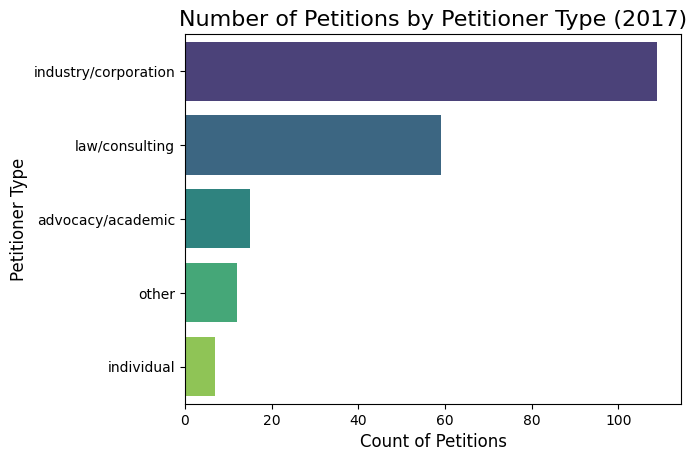

In [13]:
df['Date of Petition'] = pd.to_datetime(df['Date of Petition'], errors='coerce')
df['Last Response Date'] = pd.to_datetime(df['Last Response Date'], errors='coerce')

# calculate response time in days
df["Response Time (Days)"] = (df["Last Response Date"] - df["Date of Petition"]).dt.days

# count of petitions by submitter type 
order = df["Submitter Type"].value_counts().index
sns.countplot(data = df, y = "Submitter Type", order = order, palette = "viridis")
plt.title('Number of Petitions by Petitioner Type (2017)', fontsize=16)
plt.xlabel('Count of Petitions', fontsize=12)
plt.ylabel('Petitioner Type', fontsize=12)


#### Quick Analysis of Bar Plot:
* most petitions are filled out by either industry/corps or law/consulting
* individuals having the least 

<ipython-input-20-68d606bb9489>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df, x = "Response Time (Days)", y = "Submitter Type", order = order, palette = "plasma")


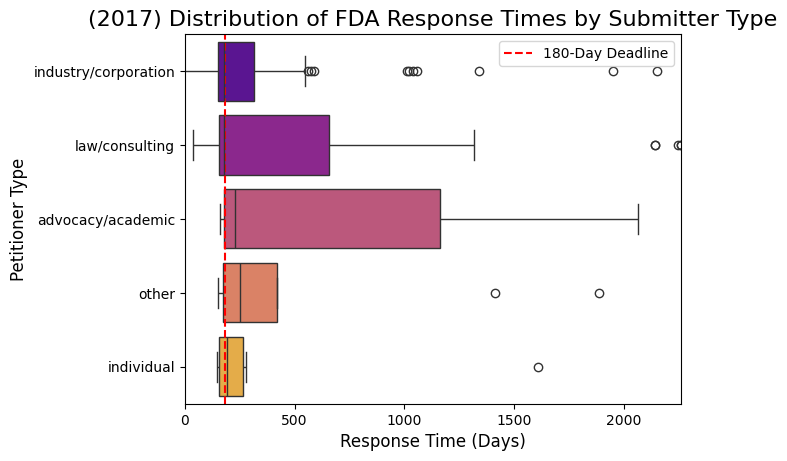

In [20]:
# response time by submitter type 
sns.boxplot(data = df, x = "Response Time (Days)", y = "Submitter Type", order = order, palette = "plasma")
plt.title("(2017) Distribution of FDA Response Times by Submitter Type", fontsize=16)
plt.xlabel('Response Time (Days)', fontsize=12)
plt.ylabel('Petitioner Type', fontsize=12)

# Limit x-axis to the 95th percentile for better readability, ignoring negative times
plt.xlim(0, df[df["Response Time (Days)"] >= 0]["Response Time (Days)"].quantile(0.95))
plt.axvline(x = 180, color = 'r', linestyle = '--', label = '180-Day Deadline')
plt.legend()

keep in mind that other category includes individuals bc haven't figured out to separate them

#### Quick Analysis of Box Plot:
* median line splits the data exactly 50/50
  * industry/corp & law/consulting get fastest responses bc their median lines are around the 180-day deadline
  * adv/acad have delayed response time from the fda
* box itself is middle 50% (boxplot is split into 25/25/25/25 -> box is middle 50)
  * industry/corp's and individual's middle 50% of data is mostly around the 180 deadline which is good bc they usually get the fda usually respond somewhat around the 180 mark
* dots are outliers, end of whiskers show minimum and maximum